In [1]:
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

In [2]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split

In [3]:
import time
import segmentation_models_pytorch as smp

## Dataset

In [4]:
DATALOADER_NUM_WORKERS=8


image_directory = "/gpfs/space/home/obedkobi/neural_net/ADE20K/images/ADE/training/"
label_directory = "/gpfs/space/home/obedkobi/neural_net/ADE20K/images/ADE/training/"

# Walk through the image directory to gather all image files 
image_files = []
for root, dirs, files in os.walk(image_directory):
    for file in files:
        if file.lower().endswith('.jpg'):
            full_path = os.path.join(root, file)
            rel_filename = '/'.join(full_path.split('/')[-3:])
            image_files.append(rel_filename)

In [5]:
# Sort the image files
image_files = sorted(image_files)

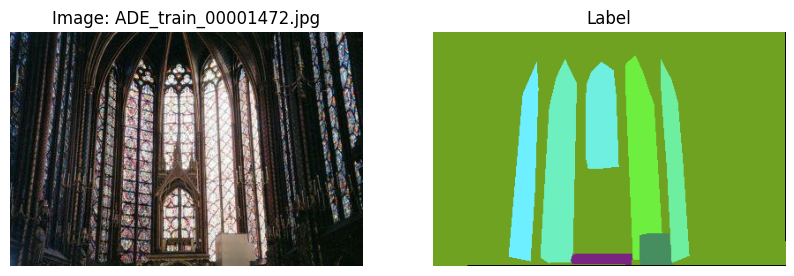

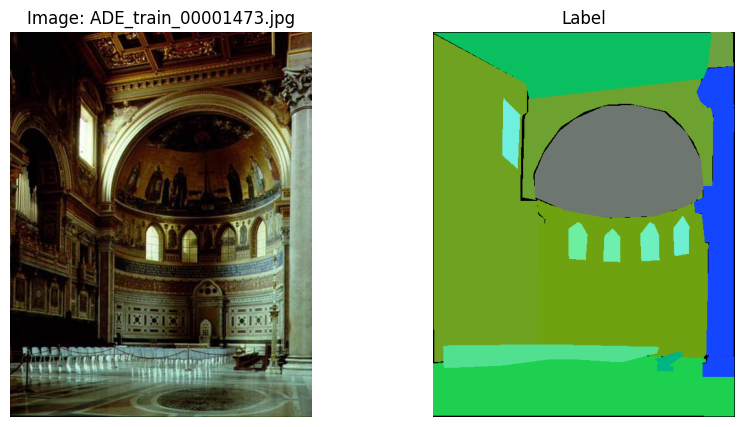

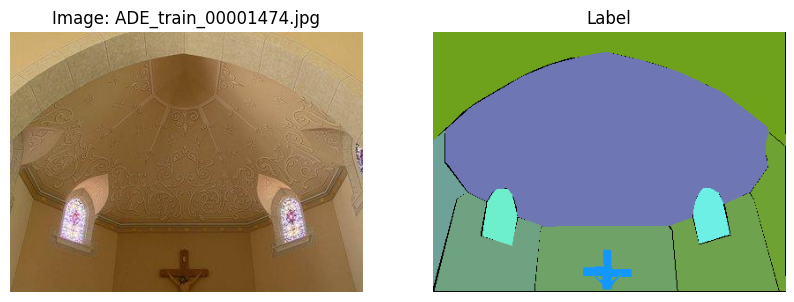

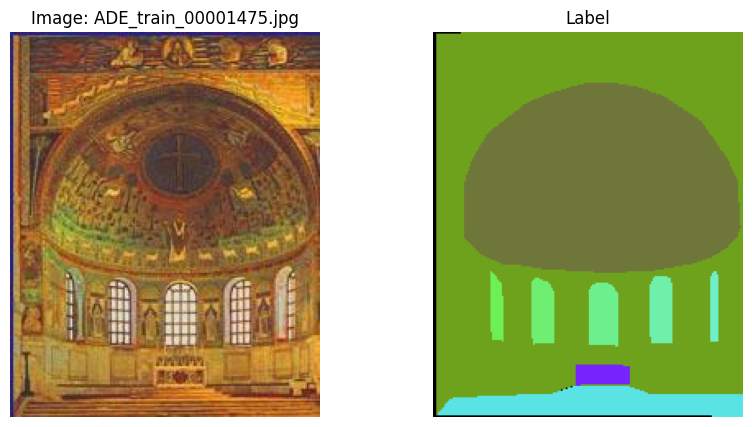

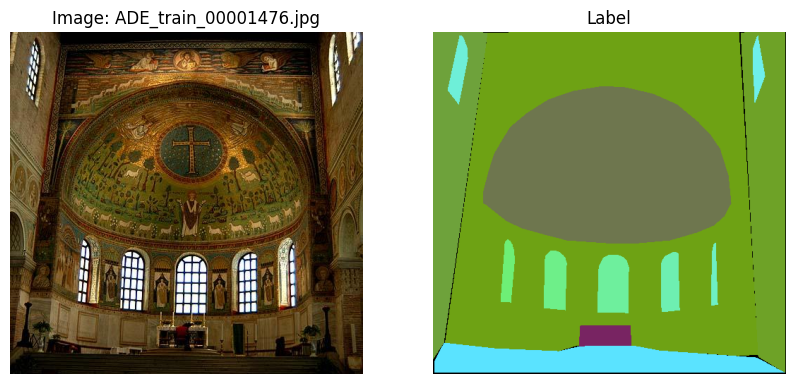

In [6]:
# print(len(image_files))
# print(image_files[1])

for i, image_file in enumerate(image_files[:5]):
    if image_file.endswith(".jpg"):
        # Read the image
        image = Image.open(os.path.join(image_directory, image_file))
        
        # Get corresponding label filename
        label_file = os.path.join(label_directory, image_file)
        # print(label_file)
        # print(os.path.exists(label_file.replace('.jpg', '_seg.png')))
        # print(label_file.replace('.jpg', '_seg.png'))
        # print(os.path.exists('/gpfs/space/home/obedkobi/neural_net/cityscapes/leftImg8bit/train/aachen/aachen_000000_000019_leftImg8bit.png'))
        if os.path.exists(label_file.replace('.jpg', '_seg.png')):
        # Read the label
            # print("hello")
            label = Image.open(label_file.replace('.jpg', '_seg.png'))
            # Plot the images and labels side by side
            fig, axes = plt.subplots(1, 2, figsize=(10, 5))
            axes[0].imshow(image)
            axes[0].set_title("Image: " + image_file.split("/")[-1])  # Add image title
            axes[0].axis('off')
            axes[1].imshow(label)
            axes[1].set_title("Label")
            axes[1].axis('off')
            plt.show()

In [7]:
print(image_files[0])

cultural/apse__indoor/ADE_train_00001472.jpg


In [21]:
ADE20K_IMAGES_BASE_PATH = "/gpfs/space/home/obedkobi/neural_net/ADE20K/images/ADE"

class ADE20KDataset(Dataset):
    def __init__(self, 
                 dataset_name,
                 image_dir, 
                 label_dir, 
                 image_files, 
                 preprocessing_fn=None, 
                 downscale_to_height=None, 
                 crop_dims=None
        ):
        self.dataset_name = dataset_name
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.image_files = image_files
        self.preprocessing_fn = preprocessing_fn
        self.resize = transforms.Resize(downscale_to_height) if downscale_to_height is not None else None
        self.crop_dims = crop_dims
        self.color_to_class = {'165': 0,
                             '3055': 1,
                             '350': 2,
                             '1831': 3,
                             '774': 4,
                             '783': 5,
                             '2684': 6,
                             '687': 7,
                             '471': 8,
                             '401': 9,
                             '1735': 10,
                             '2473': 11,
                             '2329': 12,
                             '1564': 13,
                             '57': 14,
                             '2272': 15,
                             '907': 16,
                             '724': 17,
                             '2985': 18,
                             '533': 19,
                             '1395': 20,
                             '155': 21,
                             '2053': 22,
                             '689': 23,
                             '266': 24,
                             '581': 25,
                             '2380': 26,
                             '491': 27,
                             '627': 28,
                             '2388': 29,
                             '943': 30,
                             '2096': 31,
                             '2530': 32,
                             '420': 33,
                             '1948': 34,
                             '1869': 35,
                             '2251': 36,
                             '239': 37,
                             '571': 38,
                             '2793': 39,
                             '978': 40,
                             '236': 41,
                             '181': 42,
                             '629': 43,
                             '2598': 44,
                             '1744': 45,
                             '1374': 46,
                             '591': 47,
                             '2679': 48,
                             '223': 49,
                             '47': 50,
                             '327': 51,
                             '2821': 52,
                             '1451': 53,
                             '2880': 54,
                             '480': 55,
                             '77': 56,
                             '2616': 57,
                             '246': 58,
                             '247': 59,
                             '2733': 60,
                             '14': 61,
                             '38': 62,
                             '1936': 63,
                             '120': 64,
                             '1702': 65,
                             '249': 66,
                             '2928': 67,
                             '2337': 68,
                             '1023': 69,
                             '2989': 70,
                             '1930': 71,
                             '2586': 72,
                             '131': 73,
                             '146': 74,
                             '95': 75,
                             '1563': 76,
                             '1708': 77,
                             '103': 78,
                             '1002': 79,
                             '2569': 80,
                             '2833': 81,
                             '1551': 82,
                             '1981': 83,
                             '29': 84,
                             '187': 85,
                             '747': 86,
                             '2254': 87,
                             '2262': 88,
                             '1260': 89,
                             '2243': 90,
                             '2932': 91,
                             '2836': 92,
                             '2850': 93,
                             '64': 94,
                             '894': 95,
                             '1919': 96,
                             '1583': 97,
                             '318': 98,
                             '2046': 99,
                             '1098': 100,
                             '530': 101,
                             '954': 102}
        self.num_classes = len(np.unique(list(self.color_to_class.values())))

    @staticmethod
    def get_image_files(directory):
        jpg_files = []
        for root, dirs, files in os.walk(directory):
            for file in files:
                if file.lower().endswith('.jpg'):
                    full_path = os.path.join(root, file)
                    rel_filename = '/'.join(full_path.split('/')[-3:])
                    jpg_files.append(rel_filename)
        return jpg_files
    
    def __len__(self):
        return len(self.image_files)


    def convert_label_to_mask(self, seg):
        R = seg[:,:,0]
        G = seg[:,:,1]
        mask = (R/10).astype(np.int32)*256+(G.astype(np.int32))
    
        new_mask = np.zeros(mask.shape, dtype=np.uint8)
        for class_code, id_code in self.color_to_class.items():
            new_mask[mask == int(class_code)] = id_code
        return new_mask

    
    def __getitem__(self, idx):
        image_file = self.image_files[idx]
        image_path = os.path.join(self.image_dir, image_file)
        label_path = os.path.join(self.label_dir, image_file.replace('.jpg', '_seg.png'))

        image = transforms.functional.to_tensor(Image.open(image_path)).type(torch.float32)
        label = np.array(Image.open(label_path))[:,:,:3]
        label = torch.Tensor(self.convert_label_to_mask(label)).type(torch.long).unsqueeze(0)
        
        # Apply transformations
        if self.resize:
            image = self.resize(image)
            label = self.resize(label)
        if self.crop_dims:
            params = transforms.RandomCrop.get_params(image, self.crop_dims)
            image = transforms.functional.crop(image, *params)
            label = transforms.functional.crop(label, *params)

        # Convert label from (W, H) to (C, W, H) - each class would have its own mask
        mask = F.one_hot(label, self.num_classes).squeeze(0).permute(2, 0, 1)

        # Applying standartization using the statistics of the pretrained model
        if self.preprocessing_fn:
            image = self.preprocessing_fn(image.permute(1,2,0)).permute(2,0,1)

        return (    
            image.type(torch.float32),
            mask.type(torch.float32),
        )

In [22]:
X_train, X_test = train_test_split(image_files, test_size=0.1, random_state=42)

len(X_train), len(X_test)

(23016, 2558)

In [23]:
import random

def get_subset(arr, size=0.5):
    r = random.Random(42)
    r.shuffle(arr)
    return arr[:int(len(arr) * size)]

### Model

In [24]:
ENCODER = 'resnet101'
ENCODER_WEIGHTS = 'imagenet'
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [26]:
model = smp.Unet(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=103,
)

In [27]:
train_dataset = ADE20KDataset(
    dataset_name = "ADE20K",
    image_dir = f"{ADE20K_IMAGES_BASE_PATH}/training/", 
    label_dir = f"{ADE20K_IMAGES_BASE_PATH}/training/", 
    image_files=get_subset(X_train,0.4),
    preprocessing_fn=preprocessing_fn,
    downscale_to_height=512,
    crop_dims=(512, 512)
)

In [28]:
valid_dataset = ADE20KDataset(
    dataset_name = "ADE20K",
    image_dir = f"{ADE20K_IMAGES_BASE_PATH}/validation/",
    label_dir = f"{ADE20K_IMAGES_BASE_PATH}/validation/",
    image_files = get_subset(ADE20KDataset.get_image_files(f"{ADE20K_IMAGES_BASE_PATH}/validation/"),0.4), 
    preprocessing_fn=preprocessing_fn,
    downscale_to_height=512,
    crop_dims=(512, 512)
)

In [29]:
def collate_fn(batch):
    batch_by_dataset = defaultdict(lambda: defaultdict(list))
    for item in batch:
        batch_by_dataset[item["dataset_name"]]["x"].append(
            item["image"]
        )
        batch_by_dataset[item["dataset_name"]]["y"].append(
            item["mask"]
        )
    for dataset_name, mini_batch in batch_by_dataset.items():
        batch_by_dataset[dataset_name]["x"] = torch.stack(mini_batch["x"])
        batch_by_dataset[dataset_name]["y"] = torch.stack(mini_batch["y"])
    return dict(batch_by_dataset)

In [30]:
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=8)
valid_loader = DataLoader(valid_dataset, batch_size=8, shuffle=False, num_workers=8)

In [31]:
from segmentation_models_pytorch import utils

In [32]:
loss = utils.losses.DiceLoss(activation='softmax2d')
metrics = [
    utils.metrics.IoU(threshold=0.5),
]

optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.0001),
])

In [33]:
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

In [34]:
max_score = 0
for i in range(0, 5):
    
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)
    
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model, './best_model_ade20k.pth')
        print('Model saved!')

    if i == 15:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease decoder learning rate to 1e-5!')
        


Epoch: 0
valid: 100%|█████████████████████████████| 100/100 [02:00<00:00,  1.20s/it, dice_loss - 0.2269, iou_score - 0.6475]
Model saved!

Epoch: 1
valid: 100%|█████████████████████████████| 100/100 [02:00<00:00,  1.21s/it, dice_loss - 0.2246, iou_score - 0.6444]

Epoch: 2
valid: 100%|█████████████████████████████| 100/100 [01:59<00:00,  1.19s/it, dice_loss - 0.2254, iou_score - 0.6433]

Epoch: 3
valid: 100%|█████████████████████████████| 100/100 [02:01<00:00,  1.22s/it, dice_loss - 0.2242, iou_score - 0.6444]

Epoch: 4
valid: 100%|█████████████████████████████| 100/100 [02:03<00:00,  1.24s/it, dice_loss - 0.2237, iou_score - 0.6447]


## Testing

In [39]:
best_model = torch.load('./best_model_ade20k.pth')

In [55]:
test_dataset = ADE20KDataset(
    dataset_name = "ADE20K",
    image_dir = f"{ADE20K_IMAGES_BASE_PATH}/training/", 
    label_dir = f"{ADE20K_IMAGES_BASE_PATH}/training/", 
    image_files=X_test,
    preprocessing_fn=preprocessing_fn,
    downscale_to_height=512,
    crop_dims=(512, 512)
)

test_dataloader = DataLoader(test_dataset, batch_size=8, num_workers=2)

In [41]:
loss = utils.losses.DiceLoss(activation='softmax2d')
metrics = [
    utils.metrics.IoU(threshold=0.5),
]

test_epoch = smp.utils.train.ValidEpoch(
    model=best_model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
)

logs = test_epoch.run(test_dataloader)

valid: 100%|█████████████████████████████| 320/320 [11:05<00:00,  2.08s/it, dice_loss - 0.2187, iou_score - 0.6557]


In [42]:
logs

{'dice_loss': 0.21865388900041582, 'iou_score': 0.6557489297352727}

### Prediction Evaluation

In [56]:
test_dataset_vis = ADE20KDataset(
    dataset_name = "ADE20K",
    image_dir = f"{ADE20K_IMAGES_BASE_PATH}/training/", 
    label_dir = f"{ADE20K_IMAGES_BASE_PATH}/training/", 
    image_files=X_test,
    downscale_to_height=512,
    crop_dims=(512, 512)
)

In [ ]:
for i in range(20):
    n = np.random.choice(len(test_dataset))
    
    image_vis = test_dataset_vis[n][0]
    image, gt_mask = test_dataset[n]
    
    gt_mask = gt_mask.squeeze()
    
    x_tensor = image.to(DEVICE).unsqueeze(0)
    pr_mask = best_model.predict(x_tensor).cpu().squeeze(0).argmax(dim=0).type(torch.long).numpy().round()

    # remove
    # image_resized = Image.fromarray((image_vis.permute(1,2,0).cpu().numpy() * 255).round().astype(np.uint8)).resize((960, 544))
    # mask_resized = Image.fromarray(pr_mask.astype(np.uint8)).resize((960, 544))

    image_resized = Image.fromarray((image_vis.permute(1,2,0).cpu().numpy() * 255).round().astype(np.uint8))
    mask_resized = Image.fromarray(pr_mask.astype(np.uint8))

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(image_resized)
    axes[0].set_title(f"[ADE20K] Image: {n}")
    axes[0].axis('off')
    axes[1].imshow(mask_resized, cmap='tab20')
    axes[1].set_title("Label")
    axes[1].axis('off')
    plt.tight_layout()

    # Save the plot to a file
    output_file = os.path.join("", f'output_ade20k_{n}.png')
    plt.savefig(output_file)
    
    plt.show()
    plt.close(fig)

In [48]:
# torch.cuda.empty_cache()